In [2]:
# Base import and functions

import imutils
import cv2
from imutils import contours
import os, os.path

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist, adjust_log
from skimage.restoration import denoise_tv_chambolle, denoise_wavelet, denoise_bilateral
from skimage.filters import threshold_niblack
from skimage.util import img_as_float, img_as_ubyte, img_as_uint
from skimage.morphology import reconstruction
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.morphology import disk, diamond, square
from skimage.filters import rank
from skimage.filters import threshold_mean, threshold_local
from skimage.morphology import erosion, dilation, opening, closing, binary_opening, binary_closing, binary_dilation, binary_erosion

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext line_profiler

import skimage
print("skimage: " + skimage.__version__)  # Must be greater then 0.14 for Chain Vesa

skimage: 0.14dev


## SWT Description might be here

The typical way to find text areas: you can find text regions by using stroke width transform as depicted in "Detecting Text in Natural Scenes with Stroke Width Transform " by Boris Epshtein, Eyal Ofek, and Yonatan Wexler. To be honest, if this is as fast and reliable as I believe it is, then this method is a more efficient method than my below code. You can still use the code above to remove the blueprint design though, and that may help the overall performance of the swt algorithm.

Here is a c library that implements their algorithm, but it is stated to be very raw and the documentation is stated to be incomplete. Obviously, a wrapper will be needed in order to use this library with python, and at the moment I do not see an official one offered.

The library I linked is CCV. It is a library that is meant to be used in your applications, not recreate algorithms. So this is a tool to be used, which goes against OP's want for making it from "First Principles", as stated in comments. Still, useful to know it exists if you don't want to code the algorithm yourself.

SWT operates in a few steps:  

1. Use OpenCV to extract image edges using [Canny edge
detection](https://en.wikipedia.org/wiki/Canny_edge_detector)

2. Calculate the x- and y-derivatives of the image, which can be superimposed
to calculate the image gradient. The gradient describes, for each pixel, the
direction of greatest contrast. In the case of an edge pixel, this is
synonymous with the vector normal to the edge.

3. For each edge pixel, traverse in the direction θ of the gradient until the
next edge pixel is encountered (or you fall off the image). If the
corresponding edge pixel's gradient is pointed in the opposite direction
(θ - π), we know the newly-encountered edge is roughly parallel to the
first, and we have just cut a slice (line) through a stroke. Record the stroke width,
in pixels, and assign this value to all pixels on the slice we just traversed.

4. For pixels that may belong to multiple lines, reconcile differences in those
line widths by assigning all pixels the median stroke width value. This allows 
the two strokes you might encounter in an 'L' shape to be considered with the
same, most common, stroke width.

5. Connect lines that overlap using a union-find (disjoint-set) data
structure, resulting in a disjoint set of all overlapping stroke slices. Each
set of lines is likely a single letter/character.

6. Apply some intelligent filtering to the line sets; we should eliminate
anything to small (width, height) to be a legible character, as well as
anything too long or fat (width:height ratio), or too sparse (diameter:stroke
width ratio) to realistically be a character.

7. Use a k-d tree to find pairings of similarly-stroked shapes (based on
stroke width), and intersect this with pairings of similarly-sized shapes
(based on height/width). Calculate the angle of the text between these two
characters (sloping upwards, downwards?).

8. Use a k-d tree to find pairings of letter pairings with similar
orientations. These groupings of letters likely form a word. Chain similar
pairs together.

9. Produce a final image containing the resulting words.

In [7]:
def crop_number(input_src):
    return input_src[310:310+100, 300:300+330]

from __future__ import division
from collections import defaultdict
import hashlib
import math
import os

import numpy as np
import cv2
import scipy.sparse, scipy.spatial

diagnostics = True

class SWTScrubber(object):
    @classmethod
    def scrub(cls, filepath):
        """
        Apply Stroke-Width Transform to image.
        :param filepath: relative or absolute filepath to source image
        :return: numpy array representing result of transform
        """
        canny, sobelx, sobely, theta = cls._create_derivative(filepath)
        swt = cls._swt(theta, canny, sobelx, sobely)
        shapes = cls._connect_components(swt)
        swts, heights, widths, topleft_pts, images = cls._find_letters(swt, shapes)
        word_images = cls._find_words(swts, heights, widths, topleft_pts, images)

        final_mask = np.zeros(swt.shape)
        for word in word_images:
            final_mask += word
        return final_mask

    @classmethod
    def _create_derivative(cls, filepath):
        img = cv2.imread(filepath,0)
        edges = cv2.Canny(img, 175, 320, apertureSize=3)
        # Create gradient map using Sobel
        sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=-1)
        sobely64f = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=-1)

        theta = np.arctan2(sobely64f, sobelx64f)
        if diagnostics:
            cv2.imwrite('edges.jpg',edges)
            cv2.imwrite('sobelx64f.jpg', np.absolute(sobelx64f))
            cv2.imwrite('sobely64f.jpg', np.absolute(sobely64f))
            # amplify theta for visual inspection
            theta_visible = (theta + np.pi)*255/(2*np.pi)
            cv2.imwrite('theta.jpg', theta_visible)
        return (edges, sobelx64f, sobely64f, theta)

    @classmethod
    def _swt(self, theta, edges, sobelx64f, sobely64f):
        # create empty image, initialized to infinity
        swt = np.empty(theta.shape)
        swt[:] = np.Infinity
        rays = []

        # now iterate over pixels in image, checking Canny to see if we're on an edge.
        # if we are, follow a normal a ray to either the next edge or image border
        # edgesSparse = scipy.sparse.coo_matrix(edges)
        step_x_g = -1 * sobelx64f
        step_y_g = -1 * sobely64f
        mag_g = np.sqrt( step_x_g * step_x_g + step_y_g * step_y_g )
        grad_x_g = step_x_g / mag_g
        grad_y_g = step_y_g / mag_g

        for x in range(edges.shape[1]):
            for y in range(edges.shape[0]):
                if edges[y, x] > 0:
                    step_x = step_x_g[y, x]
                    step_y = step_y_g[y, x]
                    mag = mag_g[y, x]
                    grad_x = grad_x_g[y, x]
                    grad_y = grad_y_g[y, x]
                    ray = []
                    ray.append((x, y))
                    prev_x, prev_y, i = x, y, 0
                    while True:
                        i += 1
                        cur_x = math.floor(x + grad_x * i)
                        cur_y = math.floor(y + grad_y * i)

                        if cur_x != prev_x or cur_y != prev_y:
                            # we have moved to the next pixel!
                            try:
                                if edges[cur_y, cur_x] > 0:
                                    # found edge,
                                    ray.append((cur_x, cur_y))
                                    theta_point = theta[y, x]
                                    alpha = theta[cur_y, cur_x]
                                    if math.acos(grad_x * -grad_x_g[cur_y, cur_x] + grad_y * -grad_y_g[cur_y, cur_x]) < np.pi/2.0:
                                        thickness = math.sqrt( (cur_x - x) * (cur_x - x) + (cur_y - y) * (cur_y - y) )
                                        for (rp_x, rp_y) in ray:
                                            swt[rp_y, rp_x] = min(thickness, swt[rp_y, rp_x])
                                        rays.append(ray)
                                    break
                                # this is positioned at end to ensure we don't add a point beyond image boundary
                                ray.append((cur_x, cur_y))
                            except IndexError:
                                # reached image boundary
                                break
                            prev_x = cur_x
                            prev_y = cur_y

        # Compute median SWT
        for ray in rays:
            median = np.median([swt[y, x] for (x, y) in ray])
            for (x, y) in ray:
                swt[y, x] = min(median, swt[y, x])
        if diagnostics:
            cv2.imwrite('swt.jpg', swt * 100)

        return swt

    @classmethod
    def _connect_components(cls, swt):
        # STEP: Compute distinct connected components
        # Implementation of disjoint-set
        class Label(object):
            def __init__(self, value):
                self.value = value
                self.parent = self
                self.rank = 0
            def __eq__(self, other):
                if type(other) is type(self):
                    return self.value == other.value
                else:
                    return False
            def __ne__(self, other):
                return not self.__eq__(other)

        ld = {}

        def MakeSet(x):
            try:
                return ld[x]
            except KeyError:
                item = Label(x)
                ld[x] = item
                return item

        def Find(item):
            # item = ld[x]
            if item.parent != item:
                item.parent = Find(item.parent)
            return item.parent

        def Union(x, y):
            """
            :param x:
            :param y:
            :return: root node of new union tree
            """
            x_root = Find(x)
            y_root = Find(y)
            if x_root == y_root:
                return x_root

            if x_root.rank < y_root.rank:
                x_root.parent = y_root
                return y_root
            elif x_root.rank > y_root.rank:
                y_root.parent = x_root
                return x_root
            else:
                y_root.parent = x_root
                x_root.rank += 1
                return x_root

        # apply Connected Component algorithm, comparing SWT values.
        # components with a SWT ratio less extreme than 1:3 are assumed to be
        # connected. Apply twice, once for each ray direction/orientation, to
        # allow for dark-on-light and light-on-dark texts
        trees = {}
        # Assumption: we'll never have more than 65535-1 unique components
        label_map = np.zeros(shape=swt.shape, dtype=np.uint16)
        next_label = 1
        # First Pass, raster scan-style
        swt_ratio_threshold = 3.0
        for y in range(swt.shape[0]):
            for x in range(swt.shape[1]):
                sw_point = swt[y, x]
                if sw_point < np.Infinity and sw_point > 0:
                    neighbors = [(y, x-1),   # west
                                 (y-1, x-1), # northwest
                                 (y-1, x),   # north
                                 (y-1, x+1)] # northeast
                    connected_neighbors = None
                    neighborvals = []

                    for neighbor in neighbors:
                        # west
                        try:
                            sw_n = swt[neighbor]
                            label_n = label_map[neighbor]
                        except IndexError:
                            continue
                        if label_n > 0 and sw_n / sw_point < swt_ratio_threshold and sw_point / sw_n < swt_ratio_threshold:
                            neighborvals.append(label_n)
                            if connected_neighbors:
                                connected_neighbors = Union(connected_neighbors, MakeSet(label_n))
                            else:
                                connected_neighbors = MakeSet(label_n)

                    if not connected_neighbors:
                        # We don't see any connections to North/West
                        trees[next_label] = (MakeSet(next_label))
                        label_map[y, x] = next_label
                        next_label += 1
                    else:
                        # We have at least one connection to North/West
                        label_map[y, x] = min(neighborvals)
                        # For each neighbor, make note that their respective connected_neighbors are connected
                        # for label in connected_neighbors. @todo: do I need to loop at all neighbor trees?
                        trees[connected_neighbors.value] = Union(trees[connected_neighbors.value], connected_neighbors)

        # Second pass. re-base all labeling with representative label for each connected tree
        layers = {}
        contours = defaultdict(list)
        for x in range(swt.shape[1]):
            for y in range(swt.shape[0]):
                if label_map[y, x] > 0:
                    item = ld[label_map[y, x]]
                    common_label = Find(item).value
                    label_map[y, x] = common_label
                    contours[common_label].append([x, y])
                    try:
                        layer = layers[common_label]
                    except KeyError:
                        layers[common_label] = np.zeros(shape=swt.shape, dtype=np.uint16)
                        layer = layers[common_label]

                    layer[y, x] = 1
        return layers

    @classmethod
    def _find_letters(cls, swt, shapes):
        # STEP: Discard shapes that are probably not letters
        swts = []
        heights = []
        widths = []
        topleft_pts = []
        images = []

        for label,layer in shapes.items():
            (nz_y, nz_x) = np.nonzero(layer)
            east, west, south, north = max(nz_x), min(nz_x), max(nz_y), min(nz_y)
            width, height = east - west, south - north

            if width < 8 or height < 8:
                continue

            if width / height > 10 or height / width > 10:
                continue

            diameter = math.sqrt(width * width + height * height)
            median_swt = np.median(swt[(nz_y, nz_x)])
            if diameter / median_swt > 10:
                continue

            if width / layer.shape[1] > 0.4 or height / layer.shape[0] > 0.4:
                continue

            if diagnostics:
                # print " written to image."
                cv2.imwrite('layer'+ str(label) +'.jpg', layer * 255)

            # we use log_base_2 so we can do linear distance comparison later using k-d tree
            # ie, if log2(x) - log2(y) > 1, we know that x > 2*y
            # Assumption: we've eliminated anything with median_swt == 1
            swts.append([math.log(median_swt, 2)])
            heights.append([math.log(height, 2)])
            topleft_pts.append(np.asarray([north, west]))
            widths.append(width)
            images.append(layer)

        return swts, heights, widths, topleft_pts, images

    @classmethod
    def _find_words(cls, swts, heights, widths, topleft_pts, images):
        # Find all shape pairs that have similar median stroke widths
        # print 'SWTS'
        # print swts
        # print 'DONESWTS'
        swt_tree = scipy.spatial.KDTree(np.asarray(swts))
        stp = swt_tree.query_pairs(1)

        # Find all shape pairs that have similar heights
        height_tree = scipy.spatial.KDTree(np.asarray(heights))
        htp = height_tree.query_pairs(1)

        # Intersection of valid pairings
        isect = htp.intersection(stp)

        chains = []
        pairs = []
        pair_angles = []
        for pair in isect:
            left = pair[0]
            right = pair[1]
            widest = max(widths[left], widths[right])
            distance = np.linalg.norm(topleft_pts[left] - topleft_pts[right])
            if distance < widest * 3:
                delta_yx = topleft_pts[left] - topleft_pts[right]
                angle = np.arctan2(delta_yx[0], delta_yx[1])
                if angle < 0:
                    angle += np.pi

                pairs.append(pair)
                pair_angles.append(np.asarray([angle]))

        angle_tree = scipy.spatial.KDTree(np.asarray(pair_angles))
        atp = angle_tree.query_pairs(np.pi/12)

        for pair_idx in atp:
            pair_a = pairs[pair_idx[0]]
            pair_b = pairs[pair_idx[1]]
            left_a = pair_a[0]
            right_a = pair_a[1]
            left_b = pair_b[0]
            right_b = pair_b[1]

            # @todo - this is O(n^2) or similar, extremely naive. Use a search tree.
            added = False
            for chain in chains:
                if left_a in chain:
                    chain.add(right_a)
                    added = True
                elif right_a in chain:
                    chain.add(left_a)
                    added = True
            if not added:
                chains.append(set([left_a, right_a]))
            added = False
            for chain in chains:
                if left_b in chain:
                    chain.add(right_b)
                    added = True
                elif right_b in chain:
                    chain.add(left_b)
                    added = True
            if not added:
                chains.append(set([left_b, right_b]))

        word_images = []
        for chain in [c for c in chains if len(c) > 3]:
            for idx in chain:
                word_images.append(images[idx])
                # cv2.imwrite('keeper'+ str(idx) +'.jpg', images[idx] * 255)
                # final += images[idx]

        return word_images

/home/levabd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/levabd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


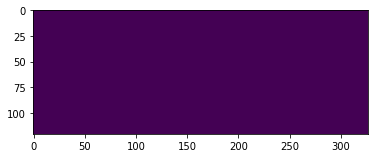

In [13]:
file_url = 'data/monitor/capture.png'

final_mask = SWTScrubber.scrub(file_url)
# final_mask = cv2.GaussianBlur(final_mask, (1, 3), 0)
# cv2.GaussianBlur(sobelx64f, (3, 3), 0)
plt.imshow(final_mask)

## Хуй там блять!!!!

100%|██████████| 145/145 [00:15<00:00,  9.35it/s]


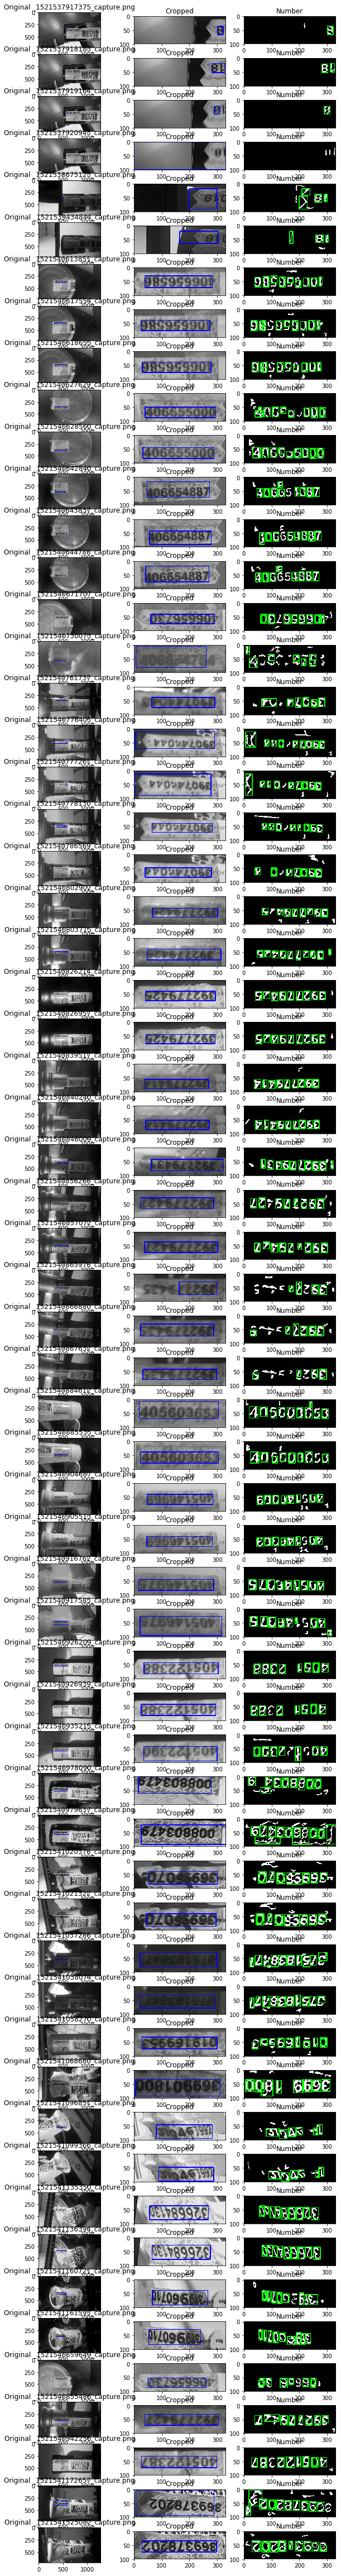

In [139]:
DIR = 'data/monitor'
filescount = len([name for name in os.listdir(DIR) if (name.endswith(".PNG") or name.endswith(".png"))])
current_file_index = 0
fig = plt.figure(figsize=(10, 200))

for filename in tqdm(os.listdir(DIR)):
    if (not (filename.endswith(".PNG") or filename.endswith(".png"))) or (current_file_index > 60):
        current_file_index += 1
        continue

    input_src = cv2.imread(os.path.join(DIR, filename))

    cropped, number = segment_mumber(input_src)

    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 1)
    imgplot = plt.imshow(cv2.cvtColor(input_src, cv2.COLOR_BGR2RGB))
    a.set_title('Original ' + filename)

    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 2)
    imgplot = plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    a.set_title('Cropped')
    
    a = fig.add_subplot(filescount, 3, 3 * current_file_index + 3)
    imgplot = plt.imshow(cv2.cvtColor(number, cv2.COLOR_BGR2RGB))
    a.set_title('Number')
    
    current_file_index += 1

plt.show()